In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt 
import cv2 
import kagglehub
import zipfile
import nibabel as nib
from PIL import Image

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from PIL import Image
import os
import numpy as np

img_size = (128, 128)
image_dir = 'liver_images'
mask_dir = 'liver_masks'

# Only include .png or .jpg files
image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

# Load and resize
images = [np.array(Image.open(p).resize(img_size)) for p in image_paths]
masks = [np.array(Image.open(p).resize(img_size)) for p in mask_paths]


In [3]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

img_size = (128, 128)
image_dir = 'liver_images'
mask_dir = 'liver_masks'

# Get only matched file names (excluding .DS_Store and ensuring both exist)
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg'))]
mask_files = [f for f in os.listdir(mask_dir) if f.lower().endswith(('.png', '.jpg'))]
matched_files = sorted(set(image_files) & set(mask_files))

# Load matched image-mask pairs
images = []
masks = []

for fname in matched_files:
    img_path = os.path.join(image_dir, fname)
    mask_path = os.path.join(mask_dir, fname)
    try:
        img = Image.open(img_path).resize(img_size)
        mask = Image.open(mask_path).resize(img_size)
        images.append(np.array(img))
        masks.append(np.array(mask))
    except:
        print(f"Skipping corrupt file: {fname}")

# Convert to numpy and preprocess
images = np.array(images, dtype=np.float32) / 255.0
masks = (np.array(masks) > 127).astype(np.float32).reshape((-1, img_size[0], img_size[1], 1))

# Split
x_train, x_valid, y_train, y_valid = train_test_split(images, masks, test_size=0.2, random_state=42)


In [4]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

# Dice loss for segmentation
def dice_loss(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

# Combined BCE + Dice Loss
def combined_bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) + 0.5 * dice_loss(y_true, y_pred)

# Build U-Net with EfficientNetB0
def build_efficientnet_unet(input_shape=(128, 128, 3)):
    base_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=input_shape)

    skip_connections = [
        base_model.get_layer(name).output
        for name in ["block2a_expand_activation", "block3a_expand_activation", 
                     "block4a_expand_activation", "block6a_expand_activation"]
    ]
    encoder_output = base_model.output

    x = encoder_output
    for idx, skip in enumerate(reversed(skip_connections)):
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, skip])
        x = Conv2D(256 // (2 ** idx), (3, 3), activation="relu", padding="same")(x)
        x = Dropout(0.3)(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(1, (1, 1), activation="sigmoid")(x)

    return Model(inputs=base_model.input, outputs=x)

model = build_efficientnet_unet(input_shape=(128, 128, 3))
model.compile(optimizer='adam', loss=combined_bce_dice_loss, metrics=['accuracy'])

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Save best model
checkpoint = ModelCheckpoint(
    "best_liver_model.keras",  
    save_best_only=True,
    monitor="val_loss",
    mode="min"
)
# Stop early if no improvement
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Training
history = model.fit(
    x_train, y_train,
    validation_data=(x_valid, y_valid),
    epochs=2,
    batch_size=32,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/2
170/170 ━━━━━━━━━━━━━━━━━━━━ 174s 953ms/step - accuracy: 0.9542 - loss: 0.2539 - val_accuracy: 0.5032 - val_loss: 1.1510
Epoch 2/2
170/170 ━━━━━━━━━━━━━━━━━━━━ 155s 911ms/step - accuracy: 0.9912 - loss: 0.0555 - val_accuracy: 0.8752 - val_loss: 0.6215


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step


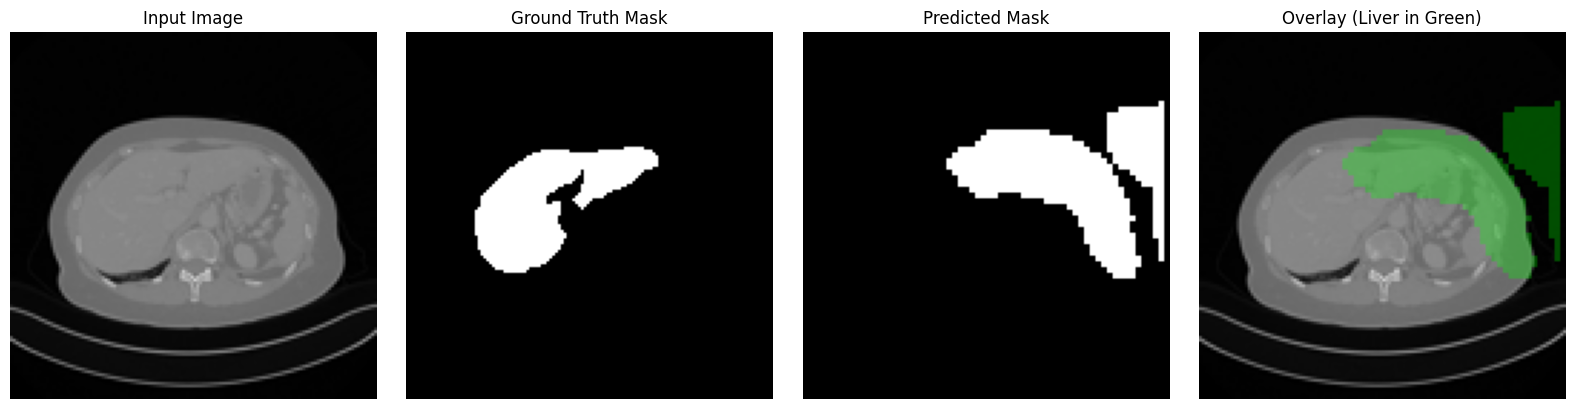

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


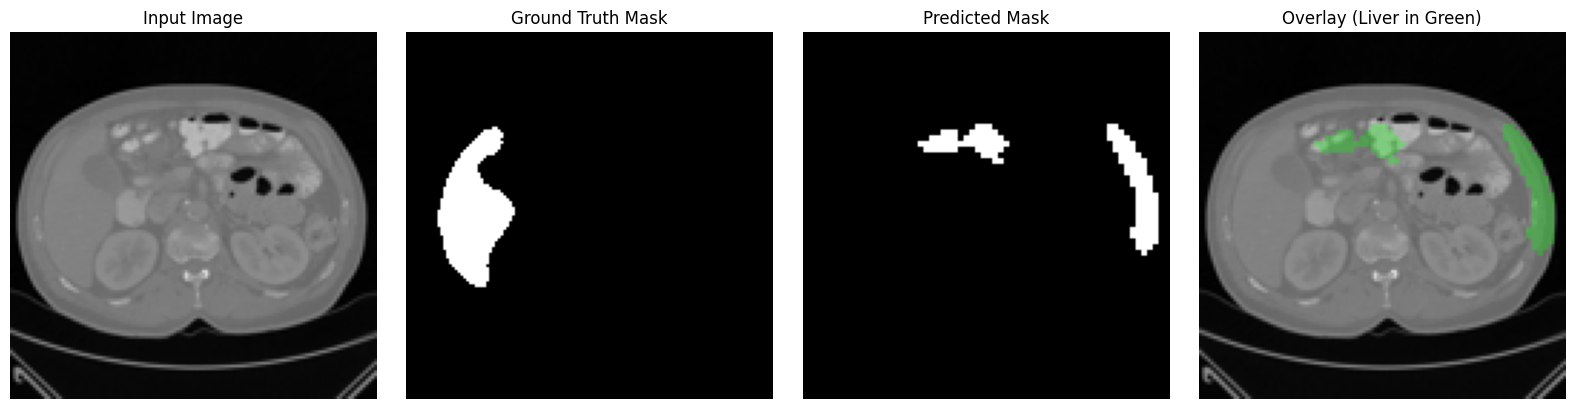

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


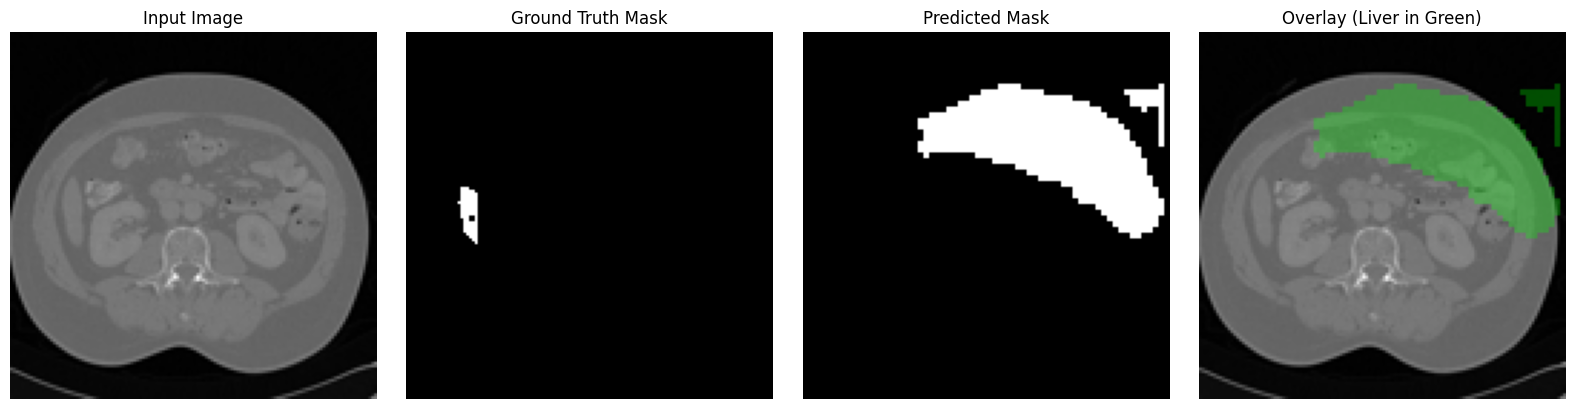

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


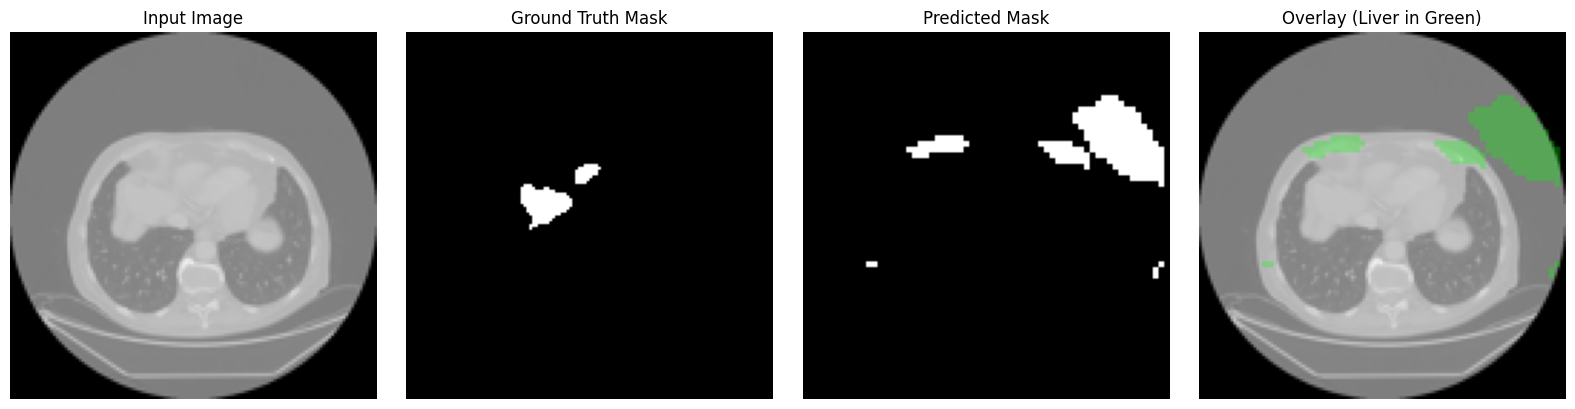

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


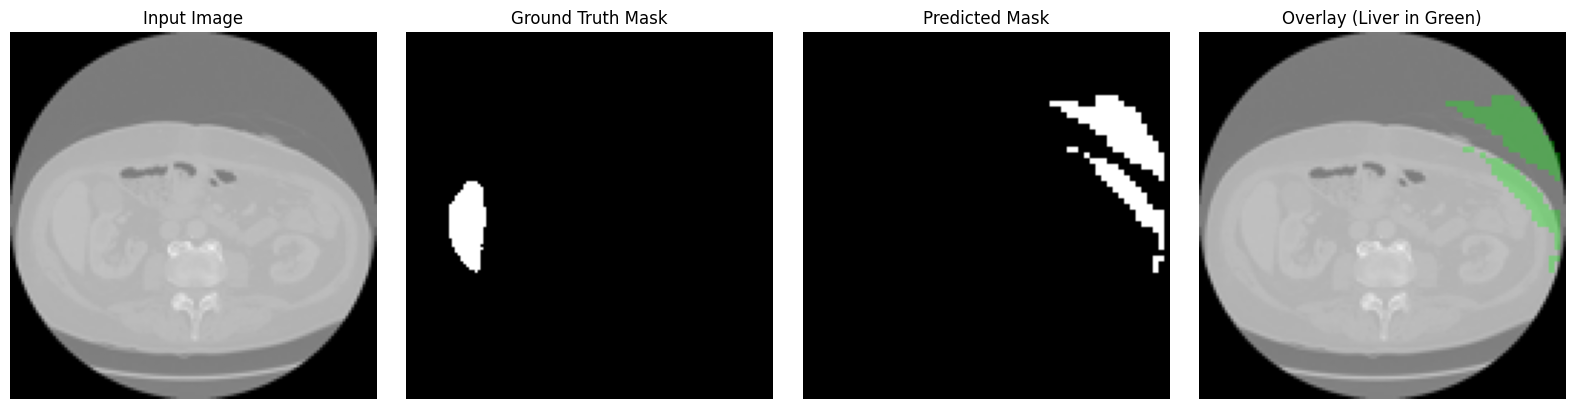

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


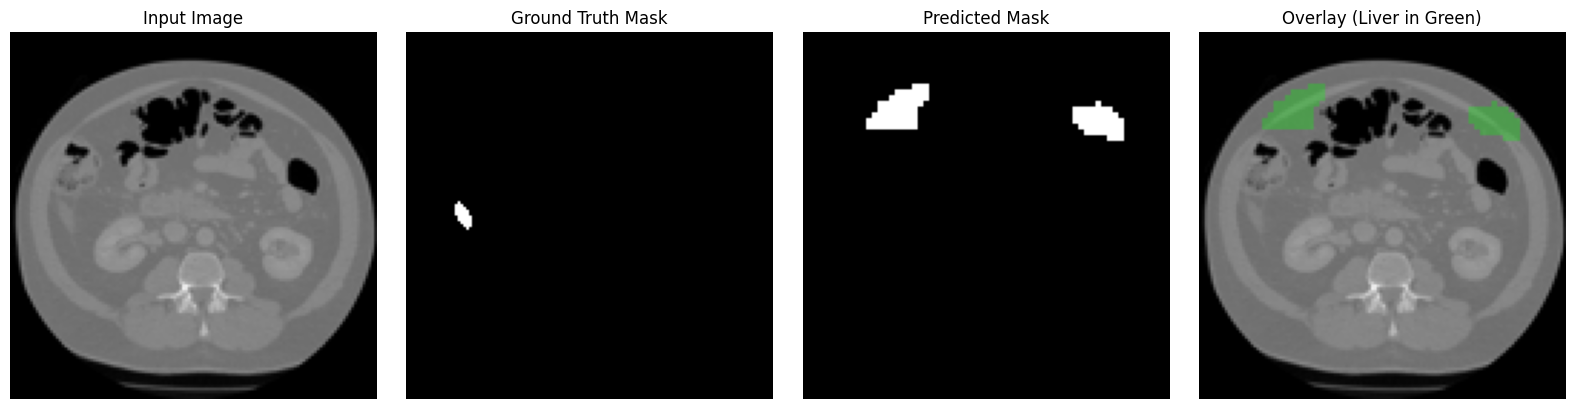

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


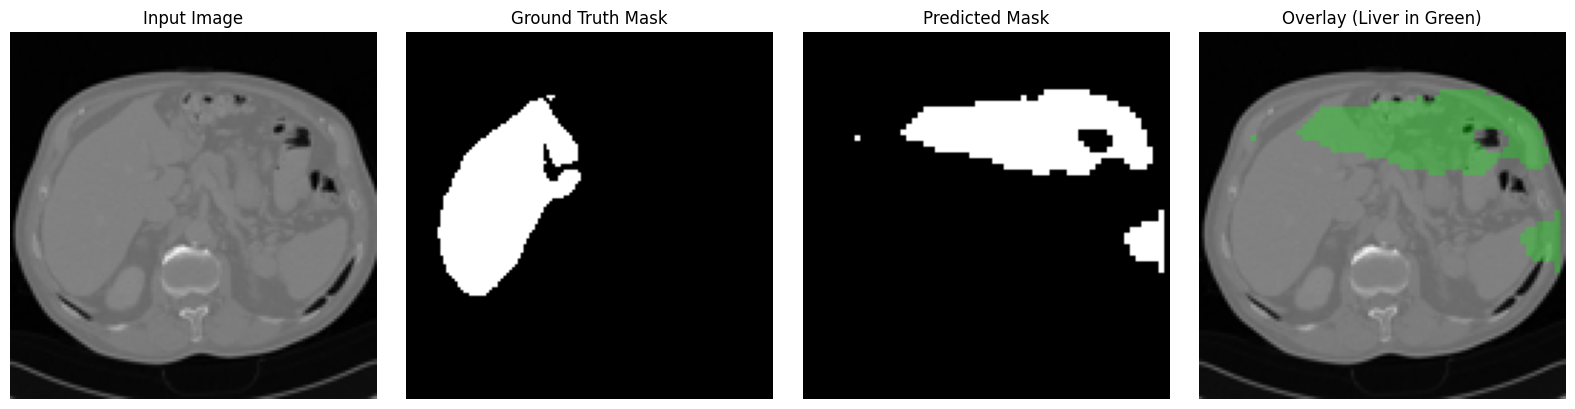

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


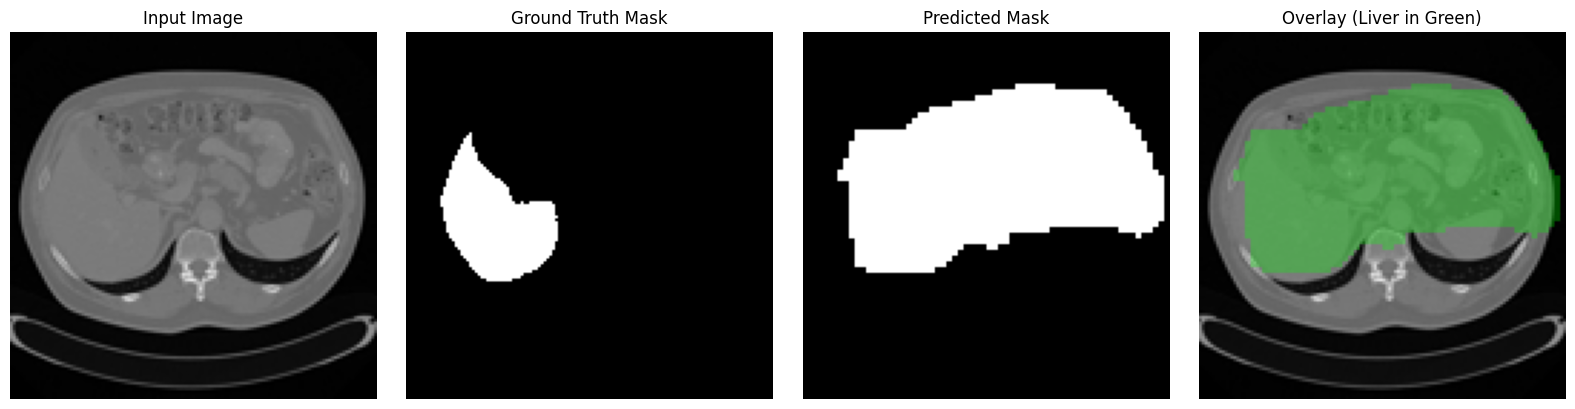

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


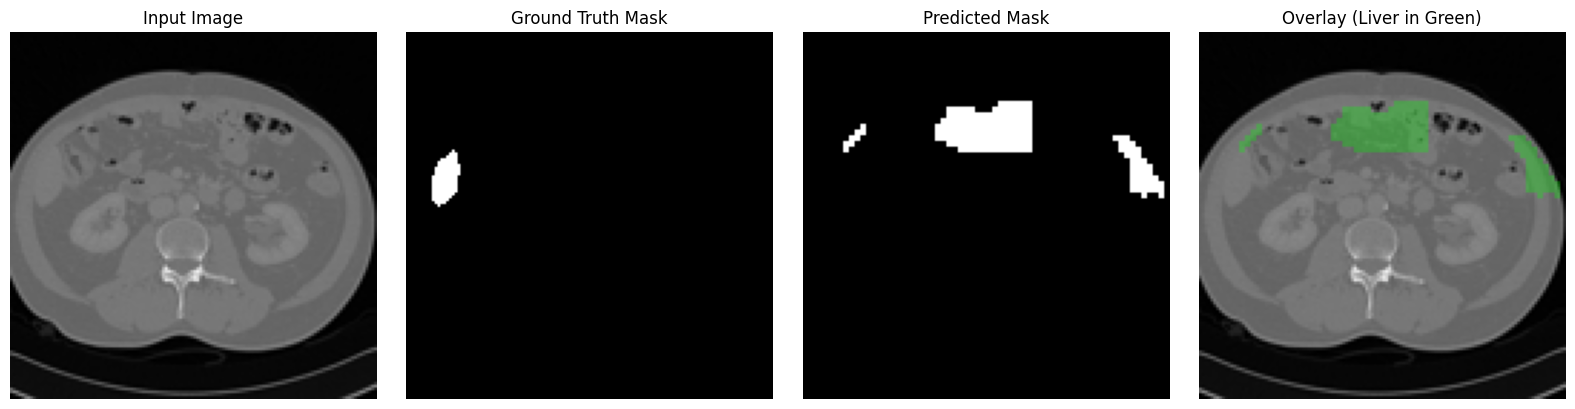

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


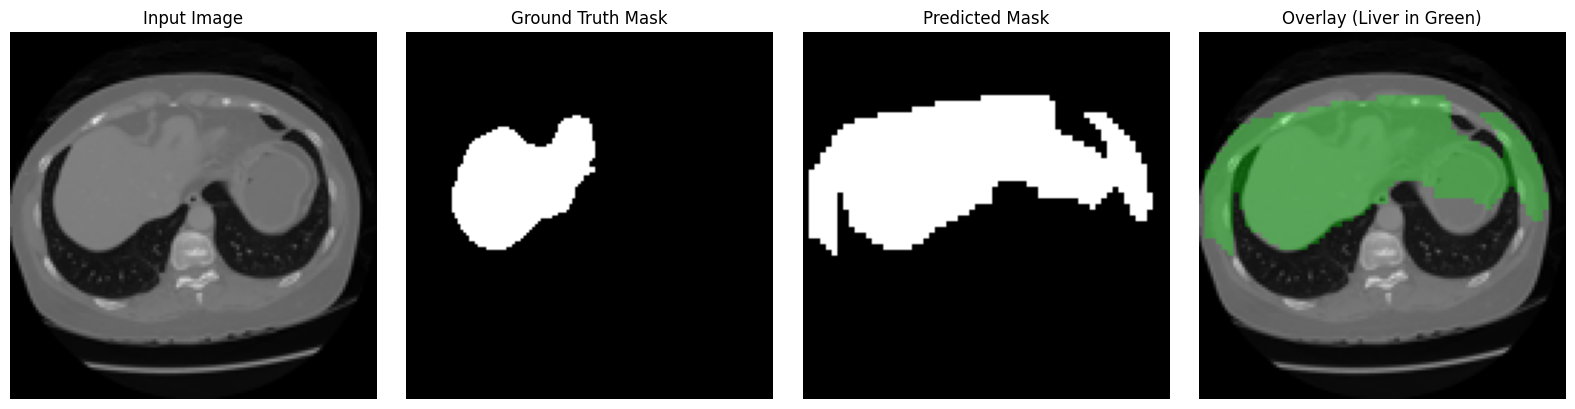

In [6]:
def visualize_prediction(index):
    img = x_valid[index]
    true_mask = y_valid[index].squeeze()
    
    # Predict the mask
    pred_mask = model.predict(img[np.newaxis, ...])[0].squeeze()
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    # Overlay: convert image to RGB and blend with green mask
    img_rgb = (img * 255).astype(np.uint8)
    overlay = img_rgb.copy()
    overlay[pred_mask == 1] = [0, 255, 0]  # Green for liver

    # Blend the original and overlay for visualization
    blended = cv2.addWeighted(img_rgb, 0.7, overlay, 0.3, 0)

    # Plotting
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 4, 1)
    plt.title("Input Image")
    plt.imshow(img)
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(true_mask, cmap='gray')
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask, cmap='gray')
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.title("Overlay (Liver in Green)")
    plt.imshow(blended)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Try on 3 random validation samples
import random
for i in random.sample(range(len(x_valid)), 10):
    visualize_prediction(i)

In [8]:
import os
import cv2
import json
import base64
import numpy as np
from PIL import Image
from tqdm import tqdm

input_folder = "png_out/NOID"
output_json_folder = "Json_Brown"
labelme_image_folder = "pngssss"  # Optional if LabelMe needs the raw image

os.makedirs(output_json_folder, exist_ok=True)
os.makedirs(labelme_image_folder, exist_ok=True)

def save_json(image_path, mask, output_path):
    # Encode image as base64
    with open(image_path, "rb") as f:
        img_bytes = f.read()
    img_base64 = base64.b64encode(img_bytes).decode("utf-8")

    # Find polygons from the binary mask
    mask = (mask > 0.5).astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    shapes = []
    for contour in contours:
        if contour.shape[0] < 3: continue
        points = contour.squeeze().tolist()
        shapes.append({
            "label": "liver",
            "points": points,
            "group_id": None,
            "shape_type": "polygon",
            "flags": {}
        })

    img = Image.open(image_path)
    json_data = {
        "version": "5.3.1",
        "flags": {},
        "shapes": shapes,
        "imagePath": os.path.basename(image_path),
        "imageData": img_base64,
        "imageHeight": img.height,
        "imageWidth": img.width
    }

    with open(output_path, "w") as f:
        json.dump(json_data, f, indent=4)

# Run predictions and generate JSON
for fname in tqdm(sorted(os.listdir(input_folder))):
    if not fname.lower().endswith(".png"):
        continue

    img_path = os.path.join(input_folder, fname)
    img = Image.open(img_path).convert("RGB").resize((256, 256))
    img_array = np.array(img) / 255.0
    pred = model.predict(np.expand_dims(img_array, axis=0))[0].squeeze()

    # Resize mask back to original
    original_size = Image.open(img_path).size[::-1]  # (height, width)
    mask_resized = cv2.resize((pred > 0.5).astype(np.uint8), original_size, interpolation=cv2.INTER_NEAREST)

    # Copy image to Images/ for LabelMe
    Image.open(img_path).save(os.path.join(labelme_image_folder, fname))

    # Save JSON
    json_path = os.path.join(output_json_folder, fname.replace(".png", ".json"))
    save_json(img_path, mask_resized, json_path)

print("✅ JSONs generated in 'Json_Scans' and images copied to 'Images'")


  0%|          | 0/446 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step


  0%|          | 1/446 [00:00<06:14,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


  1%|          | 3/446 [00:01<02:09,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


  1%|          | 4/446 [00:01<01:40,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  1%|▏         | 6/446 [00:01<01:08,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


  2%|▏         | 7/446 [00:01<01:02,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


  2%|▏         | 8/446 [00:01<00:59,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


  2%|▏         | 9/446 [00:01<00:56,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  2%|▏         | 11/446 [00:01<00:47,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  3%|▎         | 13/446 [00:01<00:42, 10.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  3%|▎         | 15/446 [00:02<00:41, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  4%|▍         | 17/446 [00:02<00:39, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  4%|▍         | 19/446 [00:02<00:37, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  5%|▍         | 21/446 [00:02<00:37, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  5%|▌         | 23/446 [00:02<00:37, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  6%|▌         | 25/446 [00:03<00:36, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  6%|▌         | 27/446 [00:03<00:36, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  7%|▋         | 29/446 [00:03<00:34, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  7%|▋         | 31/446 [00:03<00:34, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  7%|▋         | 33/446 [00:03<00:34, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


  8%|▊         | 35/446 [00:03<00:37, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  8%|▊         | 37/446 [00:04<00:36, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


  9%|▊         | 39/446 [00:04<00:37, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  9%|▉         | 41/446 [00:04<00:36, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 10%|▉         | 43/446 [00:04<00:35, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 10%|█         | 45/446 [00:04<00:34, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 11%|█         | 47/446 [00:04<00:33, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 11%|█         | 49/446 [00:05<00:33, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 11%|█▏        | 51/446 [00:05<00:33, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 12%|█▏        | 53/446 [00:05<00:32, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 12%|█▏        | 55/446 [00:05<00:32, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 13%|█▎        | 57/446 [00:05<00:31, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 13%|█▎        | 59/446 [00:05<00:31, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 14%|█▎        | 61/446 [00:06<00:31, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 14%|█▍        | 63/446 [00:06<00:30, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 15%|█▍        | 65/446 [00:06<00:30, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 15%|█▌        | 67/446 [00:06<00:30, 12.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 15%|█▌        | 69/446 [00:06<00:29, 12.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 16%|█▌        | 71/446 [00:06<00:29, 12.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 16%|█▋        | 73/446 [00:06<00:29, 12.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 17%|█▋        | 75/446 [00:07<00:29, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 17%|█▋        | 77/446 [00:07<00:29, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 18%|█▊        | 79/446 [00:07<00:29, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 18%|█▊        | 81/446 [00:07<00:29, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 19%|█▊        | 83/446 [00:07<00:31, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 19%|█▉        | 85/446 [00:08<00:30, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 20%|█▉        | 87/446 [00:08<00:30, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 20%|█▉        | 89/446 [00:08<00:30, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 20%|██        | 91/446 [00:08<00:29, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 21%|██        | 93/446 [00:08<00:29, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 21%|██▏       | 95/446 [00:08<00:28, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 22%|██▏       | 97/446 [00:09<00:28, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 22%|██▏       | 99/446 [00:09<00:29, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 23%|██▎       | 101/446 [00:09<00:29, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 23%|██▎       | 103/446 [00:09<00:29, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 24%|██▎       | 105/446 [00:09<00:28, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 24%|██▍       | 107/446 [00:09<00:28, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 24%|██▍       | 109/446 [00:10<00:28, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 25%|██▍       | 111/446 [00:10<00:27, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 25%|██▌       | 113/446 [00:10<00:28, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 26%|██▌       | 115/446 [00:10<00:28, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 26%|██▌       | 117/446 [00:10<00:28, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 27%|██▋       | 119/446 [00:10<00:27, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 27%|██▋       | 121/446 [00:11<00:27, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 28%|██▊       | 123/446 [00:11<00:26, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 28%|██▊       | 125/446 [00:11<00:26, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 28%|██▊       | 127/446 [00:11<00:26, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 29%|██▉       | 129/446 [00:11<00:25, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 29%|██▉       | 131/446 [00:11<00:26, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 30%|██▉       | 133/446 [00:12<00:26, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 30%|███       | 135/446 [00:12<00:26, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 31%|███       | 137/446 [00:12<00:26, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 31%|███       | 139/446 [00:12<00:27, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 32%|███▏      | 141/446 [00:12<00:26, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 32%|███▏      | 143/446 [00:12<00:26, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 33%|███▎      | 145/446 [00:13<00:26, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 33%|███▎      | 147/446 [00:13<00:26, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 33%|███▎      | 149/446 [00:13<00:26, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 34%|███▍      | 151/446 [00:13<00:25, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 34%|███▍      | 153/446 [00:13<00:25, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 35%|███▍      | 155/446 [00:13<00:25, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 35%|███▌      | 157/446 [00:14<00:25, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 36%|███▌      | 159/446 [00:14<00:25, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 36%|███▌      | 161/446 [00:14<00:25, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 37%|███▋      | 163/446 [00:14<00:24, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 37%|███▋      | 165/446 [00:14<00:24, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 37%|███▋      | 167/446 [00:15<00:24, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 38%|███▊      | 169/446 [00:15<00:23, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 38%|███▊      | 171/446 [00:15<00:24, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 39%|███▉      | 173/446 [00:15<00:23, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 39%|███▉      | 175/446 [00:15<00:23, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 40%|███▉      | 177/446 [00:15<00:23, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 40%|████      | 179/446 [00:16<00:22, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 41%|████      | 181/446 [00:16<00:23, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 41%|████      | 183/446 [00:16<00:23, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 41%|████▏     | 185/446 [00:16<00:22, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 42%|████▏     | 187/446 [00:16<00:22, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 42%|████▏     | 189/446 [00:16<00:22, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 43%|████▎     | 191/446 [00:17<00:23, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 43%|████▎     | 193/446 [00:17<00:22, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 44%|████▎     | 195/446 [00:17<00:22, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 44%|████▍     | 197/446 [00:17<00:22, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 45%|████▍     | 199/446 [00:17<00:22, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 45%|████▌     | 201/446 [00:18<00:22, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 46%|████▌     | 203/446 [00:18<00:21, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 46%|████▌     | 205/446 [00:18<00:21, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 46%|████▋     | 207/446 [00:18<00:21, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 47%|████▋     | 209/446 [00:18<00:21, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 47%|████▋     | 211/446 [00:18<00:20, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 48%|████▊     | 213/446 [00:19<00:20, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 48%|████▊     | 215/446 [00:19<00:20, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 49%|████▊     | 217/446 [00:19<00:20, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 49%|████▉     | 219/446 [00:19<00:20, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 50%|████▉     | 221/446 [00:19<00:19, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 50%|█████     | 223/446 [00:19<00:19, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 50%|█████     | 225/446 [00:20<00:18, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 51%|█████     | 227/446 [00:20<00:18, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 51%|█████▏    | 229/446 [00:20<00:18, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 52%|█████▏    | 231/446 [00:20<00:18, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 52%|█████▏    | 233/446 [00:20<00:18, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 53%|█████▎    | 235/446 [00:20<00:17, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 53%|█████▎    | 237/446 [00:21<00:18, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 54%|█████▎    | 239/446 [00:21<00:17, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 54%|█████▍    | 241/446 [00:21<00:17, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 54%|█████▍    | 243/446 [00:21<00:17, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 55%|█████▍    | 245/446 [00:21<00:17, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 55%|█████▌    | 247/446 [00:22<00:17, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 56%|█████▌    | 249/446 [00:22<00:16, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 56%|█████▋    | 251/446 [00:22<00:16, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 57%|█████▋    | 253/446 [00:22<00:16, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 57%|█████▋    | 255/446 [00:22<00:16, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 58%|█████▊    | 257/446 [00:22<00:16, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 58%|█████▊    | 259/446 [00:23<00:16, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 59%|█████▊    | 261/446 [00:23<00:16, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 59%|█████▉    | 263/446 [00:23<00:16, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 59%|█████▉    | 265/446 [00:23<00:16, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 60%|█████▉    | 267/446 [00:23<00:16, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 60%|██████    | 269/446 [00:23<00:15, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 61%|██████    | 271/446 [00:24<00:15, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 61%|██████    | 273/446 [00:24<00:15, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 62%|██████▏   | 275/446 [00:24<00:15, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 62%|██████▏   | 277/446 [00:24<00:14, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 63%|██████▎   | 279/446 [00:24<00:14, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 63%|██████▎   | 281/446 [00:25<00:14, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 63%|██████▎   | 283/446 [00:25<00:14, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 64%|██████▍   | 285/446 [00:25<00:13, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 64%|██████▍   | 287/446 [00:25<00:13, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 65%|██████▍   | 289/446 [00:25<00:13, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 65%|██████▌   | 291/446 [00:25<00:12, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 66%|██████▌   | 293/446 [00:26<00:12, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 66%|██████▌   | 295/446 [00:26<00:12, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 67%|██████▋   | 297/446 [00:26<00:12, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 67%|██████▋   | 299/446 [00:26<00:12, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 67%|██████▋   | 301/446 [00:26<00:11, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 68%|██████▊   | 303/446 [00:26<00:11, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 68%|██████▊   | 305/446 [00:27<00:11, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 69%|██████▉   | 307/446 [00:27<00:11, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 69%|██████▉   | 309/446 [00:27<00:11, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 70%|██████▉   | 311/446 [00:27<00:11, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 70%|███████   | 313/446 [00:27<00:11, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 71%|███████   | 315/446 [00:27<00:11, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 71%|███████   | 317/446 [00:28<00:10, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 72%|███████▏  | 319/446 [00:28<00:10, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 72%|███████▏  | 321/446 [00:28<00:10, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 72%|███████▏  | 323/446 [00:28<00:10, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 73%|███████▎  | 325/446 [00:28<00:10, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 73%|███████▎  | 327/446 [00:28<00:10, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 74%|███████▍  | 329/446 [00:29<00:09, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 74%|███████▍  | 331/446 [00:29<00:09, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 75%|███████▍  | 333/446 [00:29<00:09, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 75%|███████▌  | 335/446 [00:29<00:09, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 76%|███████▌  | 337/446 [00:29<00:09, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 76%|███████▌  | 339/446 [00:29<00:09, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 76%|███████▋  | 341/446 [00:30<00:09, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 77%|███████▋  | 343/446 [00:30<00:08, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 77%|███████▋  | 345/446 [00:30<00:08, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 78%|███████▊  | 347/446 [00:30<00:08, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 78%|███████▊  | 349/446 [00:30<00:08, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 79%|███████▊  | 351/446 [00:30<00:08, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 79%|███████▉  | 353/446 [00:31<00:07, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 80%|███████▉  | 355/446 [00:31<00:07, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 80%|████████  | 357/446 [00:31<00:07, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 80%|████████  | 359/446 [00:31<00:07, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 81%|████████  | 361/446 [00:31<00:07, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 81%|████████▏ | 363/446 [00:31<00:07, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 82%|████████▏ | 365/446 [00:32<00:07, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 82%|████████▏ | 367/446 [00:32<00:06, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 83%|████████▎ | 369/446 [00:32<00:06, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 83%|████████▎ | 371/446 [00:32<00:06, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 84%|████████▎ | 373/446 [00:32<00:06, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 84%|████████▍ | 375/446 [00:33<00:06, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 85%|████████▍ | 377/446 [00:33<00:05, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 85%|████████▍ | 379/446 [00:33<00:05, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 85%|████████▌ | 381/446 [00:33<00:05, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 86%|████████▌ | 383/446 [00:33<00:05, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 86%|████████▋ | 385/446 [00:33<00:05, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 87%|████████▋ | 387/446 [00:34<00:05, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 87%|████████▋ | 389/446 [00:34<00:05, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 88%|████████▊ | 391/446 [00:34<00:04, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 88%|████████▊ | 393/446 [00:34<00:04, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 89%|████████▊ | 395/446 [00:34<00:04, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 89%|████████▉ | 397/446 [00:35<00:04, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 89%|████████▉ | 399/446 [00:35<00:04, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 90%|████████▉ | 401/446 [00:35<00:04, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 90%|█████████ | 403/446 [00:35<00:03, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 91%|█████████ | 405/446 [00:35<00:03, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 91%|█████████▏| 407/446 [00:35<00:03, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 92%|█████████▏| 409/446 [00:36<00:03, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 92%|█████████▏| 411/446 [00:36<00:03, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 93%|█████████▎| 413/446 [00:36<00:02, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 93%|█████████▎| 415/446 [00:36<00:02, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 93%|█████████▎| 417/446 [00:36<00:02, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 94%|█████████▍| 419/446 [00:37<00:02, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 94%|█████████▍| 421/446 [00:37<00:02, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 95%|█████████▍| 423/446 [00:37<00:02, 10.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 95%|█████████▌| 425/446 [00:37<00:01, 10.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 96%|█████████▌| 427/446 [00:37<00:01, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 96%|█████████▌| 429/446 [00:37<00:01, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 97%|█████████▋| 431/446 [00:38<00:01, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 97%|█████████▋| 433/446 [00:38<00:01, 10.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 98%|█████████▊| 435/446 [00:38<00:00, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 98%|█████████▊| 437/446 [00:38<00:00, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 98%|█████████▊| 439/446 [00:38<00:00, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 99%|█████████▉| 441/446 [00:38<00:00, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 99%|█████████▉| 443/446 [00:39<00:00, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


100%|█████████▉| 445/446 [00:39<00:00, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


100%|██████████| 446/446 [00:39<00:00, 11.31it/s]

✅ JSONs generated in 'Json_Scans' and images copied to 'Images'


In [11]:
import os
import shutil

# Create destination folder
os.makedirs("mt", exist_ok=True)

# Copy all images from Images/
for fname in os.listdir("pngssss"):
    if fname.endswith(".png"):
        shutil.copy(os.path.join("pngssss", fname), os.path.join("mt", fname))

# Copy all JSONs from Json_Scans/
for fname in os.listdir("Json_Brown"):
    if fname.endswith(".json"):
        shutil.copy(os.path.join("Json_Brown", fname), os.path.join("mt", fname))

print("✅ All images and JSONs copied to 'mt/' folder.")


✅ All images and JSONs copied to 'mt/' folder.


In [13]:
!pip install labelme


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [15]:
!labelme mt/

Traceback (most recent call last):
  File "/Users/hassanimran/.pyenv/versions/3.8.17/bin/labelme", line 33, in <module>
    sys.exit(load_entry_point('labelme==5.6.0', 'console_scripts', 'labelme')())
  File "/Users/hassanimran/.pyenv/versions/3.8.17/bin/labelme", line 25, in importlib_load_entry_point
    return next(matches).load()
  File "/Users/hassanimran/.pyenv/versions/3.8.17/lib/python3.8/importlib/metadata.py", line 77, in load
    module = import_module(match.group('module'))
  File "/Users/hassanimran/.pyenv/versions/3.8.17/lib/python3.8/importlib/__init__.py", line 127, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1014, in _gcd_import
  File "<frozen importlib._bootstrap>", line 991, in _find_and_load
  File "<frozen importlib._bootstrap>", line 975, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 671, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", li